<a href="https://colab.research.google.com/github/jcanoj/UNED/blob/master/CIFAR10/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solución Ejercicio 2 Examen - Clasificación Imágenes CIFAR10


-   **Autores:** Mauricio Beltrán, Juan Antonio Vicente, Alfonso
    Carabantes
-   **Fecha:** Octubre 2020
-   revisado y comentado por **jcano**, Julio 2022

------------------------------------------------------------------------

# Introducción

Para la resolución de este ejercicio usaremos la Base de datos **CIFAR10**

El conjunto de datos [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consta de 60000 imágenes en color de 32x32 pixeles en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba. La versión preparada para su uso en python se almacena en formato tar.gz y tiene un tamaño de 163 Mb

El conjunto de datos se divide en cinco lotes de entrenamiento y un lote de prueba, cada uno con 10000 imágenes. El lote de prueba contiene exactamente 1000 imágenes seleccionadas al azar de cada clase. Los lotes de entrenamiento contienen el resto de imágenes en orden aleatorio, pero algunos lotes de entrenamiento pueden contener más imágenes de una clase que de otra. Entre ellos, los lotes de entrenamiento contienen exactamente 5000 imágenes de cada clase. 

Las clases son completamente excluyentes. No hay solapamiento entre los automóviles y los camiones. "Automóvil" incluye berlinas, todoterrenos y otros vehículos pero "Camión" incluye sólo los camiones grandes. Tampoco incluye las camionetas.

las etiquetas de clase son:

    0: airplane
    1: automobile
    2: bird
    3: cat
    4: deer
    5: dog
    6: frog
    7: horse
    8: ship
    9: truck




<img src = "cifar10.png" >

Usaremos durante el entrenamiento los datos de entrenamiento y
validación y luego finalmente para ese modelo **evaluaremos** el modelo
con los datos de test.

Durante el ejercicio, vamos a intentar usar diferentes técnicas para ver
si podemos conseguir mejorar los resultados de precisión de nuestro
entrenamiento.

La difrencia entre una convolucional y una capa densamente conectada

- la capa densa aprende patrones globales en su espacio global de entrada

- la capa convolucionales aprenden patrones locales en pequeñas ventanas de 2 dimensiones

Las estructura de un modelo es:

- entrada
- capa de convolución
- función RELU
- pool o subsampling: hará una reducción en las dimensiones alto y ancho
- capa "tradicional" densamente conetada

Plantearemos diferentes modelos con complejidades y configuraciones
diferentes en cuanto a la arquitectura, y también veremos como usar el
**Data Augmentation**, en este caso generando los nuevos gráficos de
forma estática en lugar de online mientras se ejecuta el entrenamiento.
Otro de las técnicas que usaremos será el trabajo con una red
**preentrenada**, configurando un **Feature Extraction** y **Fine
Tuning**.

Para la resolución del ejercicio hemos construido una serie de
**funciones** que nos permitirán tener un código más limpio,
reutilizable y que sea más fácil seguir el flujo del trabajo. Estas
funciones están en un fichero aparte (aunque se mostrarán al final de la
documentación del ejercicio).



# Información de versiones e Importación de funciones propias

In [2]:
import sys
import tensorflow as tf
import keras

# originalmente

# Python version
# 3.7.13 (default, Apr 24 2022, 01:04:09) 
# [GCC 7.5.0]
# Version info.
# sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
# 2.8.2

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print ("Python version ", sys.version)
print("Tensorflow version", tf.__version__)
print("Keras version ", keras.__version__)

get_available_gpus()



Python version  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Tensorflow version 2.8.2
Keras version  2.8.0


['/device:GPU:0']

Con Colab Pro, se puede accer a GPUs más rápidas. Por ejemplo, es posible acceder a GPUs más rṕaidas como la GPU T4 o P100, mientras que la mayoría de los usuarios de la versión gratuita de Colab solo pueden usar una GPU K80, que es más lenta. También es posible acceder a VMs con mayor prestación. Para ver esta información, ejecutar la siguiente celda

In [3]:
### Google Colab Pro #### 

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Jul 29 18:03:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    389MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importamos todos los módulos que vamos a usar así como las funciones que hemos creado.

In [33]:
import os
import sys
import tensorflow as tf
import pathlib
import tarfile # read, write tar files
import shutil # high level file operations
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
import random
import zipfile


def carga_dataset():

  # como son los datos?
  # 
  # el dataset original contiene un diccionario con los siguientes elementos

  # data: un array numpy de 10000x3072 de uint8s. Cada fila del array almacena una imagen 
  # en color de 32x32. Las primeras 1024 entradas contienen los valores del canal rojo, 
  # las siguientes 1024 el verde y las últimas 1024 el azul. La imagen se almacena en orden fila-mayor, 
  # de modo que las primeras 32 entradas del array son los valores del canal rojo de la primera fila de la imagen.
  #
  # labels -- una lista de 10000 números en el rango 0-9. 
  # El número en el índice i indica la etiqueta de la i-ésima imagen en la matriz de datos.

  global train_images
  global train_labels
  global test_images
  global test_labels

  # cargamos los datos en una tupla
  (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

  # Normalizamos los datos entre 0 y 1
  # nota jc: aunque python realiza la conversión de tipos automáticamente
  # en otros ejemplos en internet se suelen convertir las variables  a float32 antes de la division
  # es un best practice

  # train_images = train_images.astype('float32')
  # test_images = test_images.astype('float32')

  train_images, test_images = train_images / 255.0, test_images / 255.0

  # print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape)) # X=(50000, 32, 32, 3), y=(50000, 1)
  # print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape)) # X=(10000, 32, 32, 3), y=(10000, 1)

  # con reshape() convertimos los tensores en vectores
  # necesario para usar las RNN de tipo Dense.

  train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)
  test_images = test_images.reshape(test_images.shape[0], 32, 32, 3)

  
def crea_generadores_imagenes():
  global training_image_flow
  global validation_image_flow
  global test_image_flow
  global training_generator
  global validation_generator
  global test_generator

  training_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
  
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

  training_image_flow = training_generator.flow(
    train_images,
    train_labels,
    batch_size=32)
  
  test_image_flow = test_generator.flow(
    test_images,
    test_labels,
    batch_size = 32,
    shuffle = False)

  
def visualiza_imagenes_random():
  class_names = ['avion', 'coche', 'pajaro', 'gato', 'ciervo',
               'perro', 'rana', 'caballo', 'barco', 'camion']

  plt.figure(figsize=(10,10))
  for i in range(25):
    n = random.randint(1, 500)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[n], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[n][0]])
  plt.show()


def crea_modelo_1():
  # 32, 64, adam
  # 
  # esto es:  después de la capa de entrada tenemos 1xConv2D-32, 1xConv2D-64  y
  # por supuesto las capas densas con relu/softmax
  # en el compilado, los hiperparámetros:
  # optimizador = adam
  # función de perdida = crossentropy
  # métrica = accuracy

  # otras notas:

  # la última capa tiene que ser densa; el número de neuronas
  # tiene que coincidir con el número de categorías (10)
  # softmax es utlizado por ser una clasificacion multiple. Nos devuelve 
  # valores entre 0 y 1 que pueden ser interpretados como probabilidades

  # adam es un buen optimizador para usar por defecto

  # como la base de datos está balanceada podemos usar accuracy como métrica. 

  modelo = tf.keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(10, activation='softmax'))

  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def crea_modelo_2():
  
  # 64,128, adam

  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(10, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def crea_modelo_3():
  
  # 64, 128, 128 adam Dropout Batchnormalization

  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(tf.keras.layers.Dropout(.2))
  modelo.add(keras.layers.Dense(10, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def crea_modelo_4():
  
  # 64,128, 128 adam Dropout Batch Normalization

  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(10, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def entrena_modelo(modelo):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    train_images,
    train_labels,
    epochs = 10,
    validation_data = (test_images,test_labels),
    batch_size = 64 )
  return history

def entrena_modelo_augmentation(modelo):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  crea_generadores_imagenes()
  history = modelo.fit(
    training_image_flow,
    epochs = 10,
    validation_data = (test_images,test_labels),
    batch_size = 64 )
  return history

               
def muestra_historico_entrenamiento(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(10)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

def guarda_modelo(modelo, nombre_modelo):
  modelo.save(nombre_modelo, save_format = "h5")

def carga_modelo(nombre_modelo):
  modelo = tf.keras.models.load_model(nombre_modelo)
  return modelo

def evalua_modelo(modelo):
  evalua = modelo.evaluate(test_images,test_labels)
  return evalua

def funcion1():
    return 1


# Descarga de las imágenes

Vamos automatizar la descarga de las imágenes que vamos a usar.

In [5]:
carga_dataset()

170508288/170498071 [==============================] - 2s 0us/step


# Visualización de Imágenes

Vamos a mostrar varias imágenes de entrenamiento.

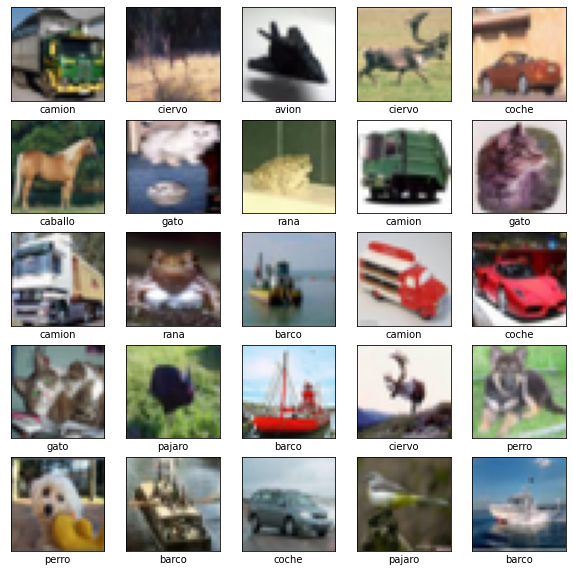

In [31]:
visualiza_imagenes_random()

Vamos a pasar a ver los diferentes modelos que vamos a probar.

# Modelo 1 ( 32,64, adam)

En este modelo vamos a tener:

-   Capa **convolución** con 32 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa para **aplanar** la información
-   Capa **dénsamente** conectada de 512 neuronas y activación **relu**
-   Capa de **salida** de 10 neuronas y activación **softmax** que nos da
    la clasificación

## Creamos el modelo


In [7]:
modelo_1 = crea_modelo_1()
modelo_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2

## Entrenamos el modelo

In [8]:

history_1 = entrena_modelo(modelo_1)

Epoch 1/10
782/782 [==============================] - 16s 7ms/step - loss: 1.3708 - accuracy: 0.5135 - val_loss: 1.0705 - val_accuracy: 0.6232
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9750 - accuracy: 0.6585 - val_loss: 0.9504 - val_accuracy: 0.6663
Epoch 3/10
782/782 [==============================] - 4s 6ms/step - loss: 0.8164 - accuracy: 0.7143 - val_loss: 0.9143 - val_accuracy: 0.6800
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6929 - accuracy: 0.7570 - val_loss: 0.8400 - val_accuracy: 0.7114
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5670 - accuracy: 0.8011 - val_loss: 0.8144 - val_accuracy: 0.7287
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 0.4508 - accuracy: 0.8424 - val_loss: 0.8773 - val_accuracy: 0.7128
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3437 - accuracy: 0.8814 - val_loss: 0.9667 - val_accuracy: 0.7186
Epoch

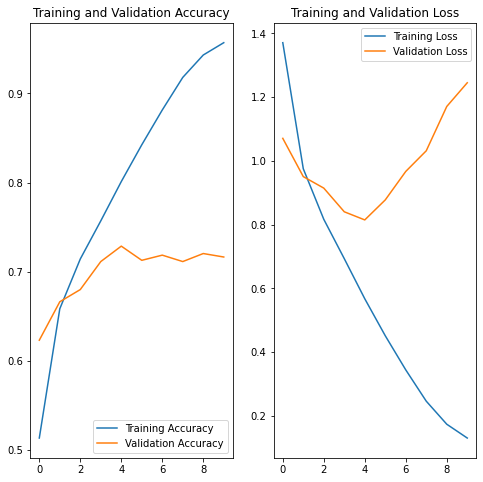

In [9]:
muestra_historico_entrenamiento(history_1)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_1,"modelo_1_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [11]:
# modelo_1 = carga_modelo("modelo_1_cifar10")
evalua_1 = evalua_modelo(modelo_1)
print(evalua_1)

313/313 [==============================] - 2s 7ms/step - loss: 1.2450 - accuracy: 0.7165
[1.2449979782104492, 0.7164999842643738]


# Modelo 2 ( 64,128, 128 adam)

Ampliamos el modelo con una capa de convolución y pooling más y mayor
número de filtros

En este modelo vamos a tener:

-   Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa para **aplanar** la información
-   Capa **dénsamente** conectada de 512 neuronas y activación **relu**
-   Capa de **salida** de 1 neurona y activación **sigmoid** que nos da
    la clasificación
-   Optimizador **adam**

## Creamos el modelo

In [ ]:
modelo_2 = crea_modelo_2()
modelo_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 128)       

## Entrenamos el modelo

In [ ]:
history_2 = entrena_modelo(modelo_2)

Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 1.3757 - accuracy: 0.5042 - val_loss: 1.0418 - val_accuracy: 0.6345
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9397 - accuracy: 0.6714 - val_loss: 0.9126 - val_accuracy: 0.6837
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.7609 - accuracy: 0.7351 - val_loss: 0.8249 - val_accuracy: 0.7115
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6302 - accuracy: 0.7795 - val_loss: 0.8152 - val_accuracy: 0.7264
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5179 - accuracy: 0.8184 - val_loss: 0.7654 - val_accuracy: 0.7448
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4172 - accuracy: 0.8528 - val_loss: 0.7746 - val_accuracy: 0.7445
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3204 - accuracy: 0.8876 - val_loss: 0.8583 - val_accuracy: 0.7539
Epoch 

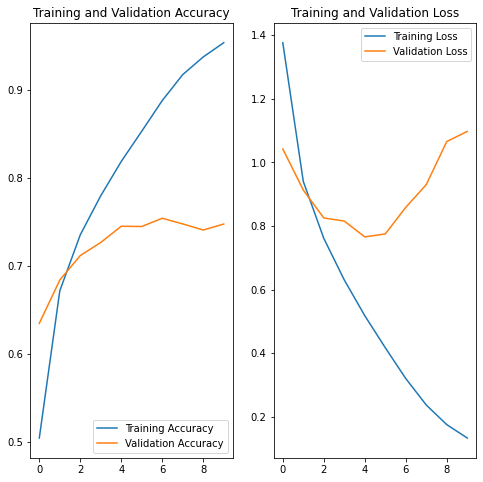

In [ ]:
muestra_historico_entrenamiento(history_2)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo( modelo_2, "modelo_2_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_2 = carga_modelo("modelo_2_cifar10")
evalua_2 = evalua_modelo(modelo_2)
print(evalua_2)

313/313 [==============================] - 1s 3ms/step - loss: 1.0969 - accuracy: 0.7473
[1.0969083309173584, 0.7473000288009644]


# Modelo 3 ( 64,128, 128 adam Dropout BatchNormalization)

Vamos a construir ahora un modelo más complejo en el que vamos a añadir
más filtros, así como regularización mediante dropout para conseguir
mejor generalización.

En este modelo vamos a tener: 
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **pooling** tipo maxpooling de tamaño 2x2 
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** - Capa de **pooling** tipo maxpooling de tamaño
2x2 
- Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **pooling** tipomaxpooling de tamaño 2x2 
- Capa para **aplanar** la información 
- Capa **dénsamente** conectada de 512 neuronas y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **dropout** quitando el 25% de las neuronas. 
- Capa de **salida** de 1 neurona y activación **sigmoid** que nos da la clasificación

## Creamos el modelo

In [12]:
modelo_3 = crea_modelo_3()
modelo_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

## Entrenamos el modelo

In [13]:
history_3 = entrena_modelo(modelo_3)

Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 1.2584 - accuracy: 0.5705 - val_loss: 1.1248 - val_accuracy: 0.6138
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.8250 - accuracy: 0.7143 - val_loss: 0.8060 - val_accuracy: 0.7215
Epoch 3/10
782/782 [==============================] - 7s 8ms/step - loss: 0.6625 - accuracy: 0.7695 - val_loss: 0.7987 - val_accuracy: 0.7314
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.5519 - accuracy: 0.8063 - val_loss: 0.8529 - val_accuracy: 0.7119
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4588 - accuracy: 0.8391 - val_loss: 0.9097 - val_accuracy: 0.7080
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.3681 - accuracy: 0.8705 - val_loss: 0.8523 - val_accuracy: 0.7380
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2961 - accuracy: 0.8967 - val_loss: 0.9813 - val_accuracy: 0.7221
Epoch 

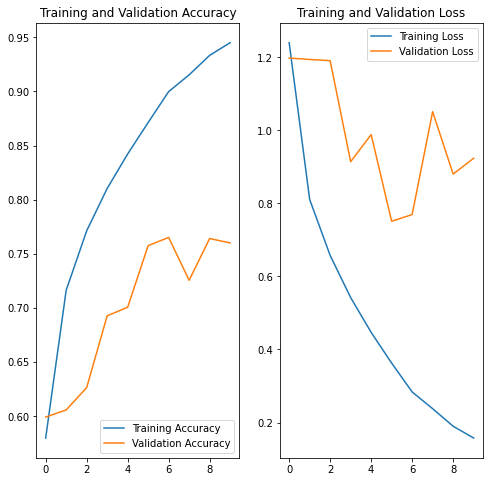

In [ ]:
muestra_historico_entrenamiento(history_3)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_3,"modelo_3_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_3 = carga_modelo("modelo_3_cifar10")
evalua_3 = evalua_modelo(modelo_3)
print(evalua_3)


313/313 [==============================] - 1s 3ms/step - loss: 0.9236 - accuracy: 0.7601
[0.9236047863960266, 0.7601000070571899]


# Modelo 4 ( 64,128, 128 adam  Augmentation)

Vamos a aplicar la técnica del **Data Augmentation** a nuestro conjuto
de imágenes. De esta manera, con las transformaciones a las imágenes conseguiremos imágenes "nuevas" para poder tener más imágenes para entrenar nuestro modelo y poder conseguir que generalice mejor (no haya tanto sobreajuste).
En cuanto la arquitectura seguiremos manteniendo la misma que teníamos.

## Creamos el modelo

In [17]:
modelo_4 = crea_modelo_4()
modelo_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 128)       

## Entrenamos el modelo

Usamos el data augmentation para generar las nuevas imágenes durante el entrenamiento.

In [34]:
history_4 = entrena_modelo_augmentation(modelo_4)


Epoch 1/10
1563/1563 [==============================] - 42s 27ms/step - loss: 1.6222 - accuracy: 0.0968 - val_loss: 1.1979 - val_accuracy: 0.0564
Epoch 2/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.2868 - accuracy: 0.0949 - val_loss: 1.1001 - val_accuracy: 0.0807
Epoch 3/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.1491 - accuracy: 0.0994 - val_loss: 0.9385 - val_accuracy: 0.1252
Epoch 4/10
1563/1563 [==============================] - 38s 24ms/step - loss: 1.0591 - accuracy: 0.0996 - val_loss: 0.9875 - val_accuracy: 0.1022
Epoch 5/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9981 - accuracy: 0.1000 - val_loss: 0.9094 - val_accuracy: 0.1407
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9486 - accuracy: 0.1010 - val_loss: 0.8472 - val_accuracy: 0.0860
Epoch 7/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9068 - accuracy: 0.1000 - val_loss: 0.8095 -

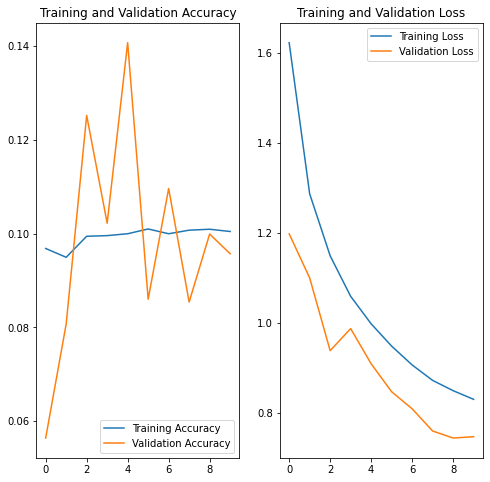

In [35]:
muestra_historico_entrenamiento(history_4)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [36]:
guarda_modelo(modelo_4,"modelo_4_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [37]:
# modelo_4 = carga_modelo("modelo_4_cifar10")
evalua_4 = evalua_modelo(modelo_4)
print(evalua_4)

313/313 [==============================] - 1s 3ms/step - loss: 0.7474 - accuracy: 0.0957
[0.7474330067634583, 0.09570000320672989]


# Modelo 5 Uso de Red Preentrenado Feature Extraction

Vamos a usar una red **Pre-Entrenada** para implementar el clasificador,
en este caso usaremos la red **VGG16**. Usaremos la técnica de
**Extracción de features** que nos permite quitar de la red
convolucional la parte final del clasificador y poner la nuestra para la
clasificación binaria que queremos hacer. Hay que tener en cuenta que
esta red neuronal está pre-entrenada sobre más de 1 millón de imágenes
(ttp://www.image-net.org) y categoriza en 1.000 categorías.


La extracción de características consiste en utilizar las
representaciones aprendidas por una red anterior para extraer
características interesantes de nuevas muestras.

Estas características se ejecutan a través de un nuevo clasificador, que
se entrena desde cero.

Vamos a instanciar una red preentrenada **VGG16** que es una de las
redes que vienen incluidas en Keras.


In [38]:
# Modelo base
modelo_base_vgg16 = tf.keras.applications.VGG16( weights='imagenet', input_shape=(32, 32, 3),include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


Construimos el modelo añadiendo la capa de clasificación que nosotros
necesitamos, además de **congelar (no entrenable)** los parámetros ya entrenados de
**VGG16**.

In [39]:
modelo_base_vgg16.trainable = False

modelo_5 = keras.Sequential()
modelo_5.add(modelo_base_vgg16)
modelo_5.add(keras.layers.Flatten())
modelo_5.add(keras.layers.Dense(256, activation='relu'))
modelo_5.add(keras.layers.Dense(10, activation='softmax'))
modelo_5.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
modelo_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


## Entrenamos el modelo

In [40]:
history_5 = entrena_modelo(modelo_5)

Epoch 1/10
782/782 [==============================] - 12s 14ms/step - loss: 1.3767 - accuracy: 0.5201 - val_loss: 1.2523 - val_accuracy: 0.5610
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 1.1844 - accuracy: 0.5851 - val_loss: 1.2033 - val_accuracy: 0.5768
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 1.1226 - accuracy: 0.6083 - val_loss: 1.1655 - val_accuracy: 0.5896
Epoch 4/10
782/782 [==============================] - 12s 15ms/step - loss: 1.0731 - accuracy: 0.6260 - val_loss: 1.1320 - val_accuracy: 0.6010
Epoch 5/10
782/782 [==============================] - 12s 16ms/step - loss: 1.0329 - accuracy: 0.6376 - val_loss: 1.1260 - val_accuracy: 0.6034
Epoch 6/10
782/782 [==============================] - 12s 16ms/step - loss: 0.9983 - accuracy: 0.6517 - val_loss: 1.1209 - val_accuracy: 0.6081
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.9679 - accuracy: 0.6612 - val_loss: 1.1185 - val_accuracy:

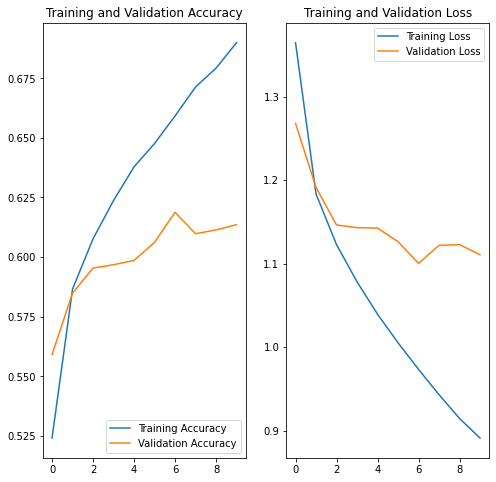

In [ ]:
muestra_historico_entrenamiento(history_5)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_5,"modelo_5_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_5 = carga_modelo("modelo_5_cifar10")
evalua_5 = evalua_modelo(modelo_5)
print(evalua_5)

313/313 [==============================] - 4s 10ms/step - loss: 1.1107 - accuracy: 0.6136
[1.1107211112976074, 0.6136000156402588]


# Modelo 6 Uso de Red Preentrenado Fine Tunning

Vamos a usar una red **Pre-Entrenada** para implementar el clasificador,
en este caso usaremos la red **VGG16**). Usaremos la técnica de **Fine
Tunning** que nos permite por un lado entrenar las últimas capas de
convolución con nuestras imágenes de entrenamiento y por otro poner la
parte final del clasificador con las capas densamente conectadas, y así
poder obtener una mejor aproximación con nuestras imágenes. Hay que
tener en cuenta que esta red neuronal está pre-entrenada sobre más de 1
millón de imágenes (ttp://www.image-net.org) y categoriza en 1.000
categorías.

Vamos a instanciar una red preentrenada **VGG16** que es una de las
redes que vienen incluidas en Keras.


In [ ]:
# Modelo base
modelo_base_vgg16_ft = tf.keras.applications.VGG16( weights='imagenet', input_shape=(32, 32, 3),include_top=False)

Construimos el modelo añadiendo la capa de clasificación que nosotros
necesitamos, además de **congelar (no entrenable)** los parámetros ya entrenados de **VGG16** hasta el bloque llamado **block5_conv3**.

In [ ]:
#modelo_base_vgg16.trainable = False
modelo_base_vgg16_ft.trainable = True

set_trainable = False
for layer in modelo_base_vgg16_ft.layers:
# A partir de esta capa ya se convierte en entrable 
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

modelo_6 = keras.Sequential()
modelo_6.add(modelo_base_vgg16_ft)
modelo_6.add(keras.layers.Flatten())
modelo_6.add(keras.layers.Dense(256, activation='relu'))
modelo_6.add(keras.layers.Dense(10, activation='softmax'))
modelo_6.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
modelo_6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dense_21 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________


## Entrenamos el modelo

In [ ]:
history_6 = entrena_modelo(modelo_6)

Epoch 1/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0626 - accuracy: 0.9803 - val_loss: 1.7664 - val_accuracy: 0.7430
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0674 - accuracy: 0.9787 - val_loss: 1.7525 - val_accuracy: 0.7469
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0615 - accuracy: 0.9813 - val_loss: 1.7969 - val_accuracy: 0.7378
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0600 - accuracy: 0.9810 - val_loss: 1.8606 - val_accuracy: 0.7438
Epoch 5/10
782/782 [==============================] - 17s 22ms/step - loss: 0.0598 - accuracy: 0.9820 - val_loss: 1.9723 - val_accuracy: 0.7380
Epoch 6/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0625 - accuracy: 0.9812 - val_loss: 1.8548 - val_accuracy: 0.7477
Epoch 7/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0495 - accuracy: 0.9852 - val_loss: 1.8597 - val_accuracy:

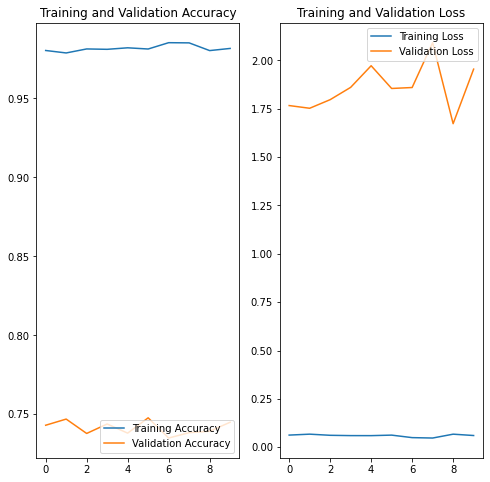

In [ ]:
muestra_historico_entrenamiento(history_6)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_6,"modelo_6_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
#modelo_6 = carga_modelo("modelo_6_cifar10")
evalua_6 = evalua_modelo(modelo_6)
print(evalua_6)

313/313 [==============================] - 3s 10ms/step - loss: 1.9547 - accuracy: 0.7449
[1.9547367095947266, 0.7448999881744385]


# Conclusiones

Hemos podido ir viendo con los diferentes modelos desde el más simple al
más complejo, pasando por el uso del Data Augmentation o usando redes
preentrenadas, que hemos conseguido ir mejorando en nuestros resultados
en el **accuracy** en los valores de test.

Parece claro que el mejor resultado lo hemos alcanzado con el uso del
**Fine tuning**.

Con esta primera aproximación podríamos intentar afinar más resultados
probando con diferentes **optimizadores** y sus parámetros, con usar un
mayor número de **épocas** de entrenamiento o incluso usar otras
**funciones de activación**.

# Referencias

Internet contiene muchos otros análisis de este conjunto de datos. Algunos ejemplos:

- [DataSmarts: como entrenar una red neuronal en cifar-10 con keras](https://datasmarts.net/es/como-entrenar-una-red-neuronal-en-cifar-10-con-keras/)
- [towards data science: cifar-10 image classification in tensorflow](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c)
- [Machine Learning Mastery: pooling layers for convolutional neural networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)
- [Machine Learning Mastery: how to develop a cnn from scratch for cifar 10 photo classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [python-course.eu: introduction to tensorflow](https://python-course.eu/machine-learning/introduction-to-tensorflow.php)
